In [1]:
import pandas as pd
import numpy as np
from readFile import split_into_values, toRPdata
from sklearn.preprocessing import StandardScaler
# columns 와 value는 사용자 입력

df = pd.read_csv('resources/Dataset1.csv')
columns = ['Process', 'Step']
value = ['Value']

df = df.loc[:, columns + value] #('chip', 'wire', 'value')는 사용자 입력
size = 96
result = split_into_values(df, columns)

# dataframe -> list
result_list = result.values.tolist()


def Standard(data):
    SS = StandardScaler().fit(data)
    scaled = SS.transform(data)
    return scaled

# result_list transpose
result_T = [list(x) for x in zip(*result_list)]

# minmax 정규화
result_scaled = Standard(result_T)

# 다시 result transpose 해서 원래대로
result_scaled = [list(x) for x in zip(*result_scaled)]

from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

# 2. 시계열 셋 크기 변경
result_ = TimeSeriesResampler(sz=size).fit_transform(result_scaled)

In [2]:
data = result_.reshape(result_.shape[0], 1, size)
X = toRPdata(data, threshold='point', percentage=30)
# X = toRPdata(data)
    
X_scaled = np.expand_dims(X, axis=3)
X_scaled.shape

(300, 96, 96, 1)

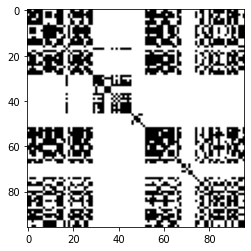

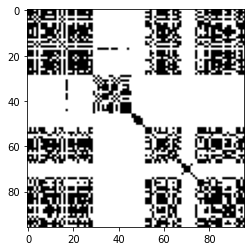

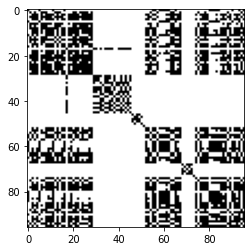

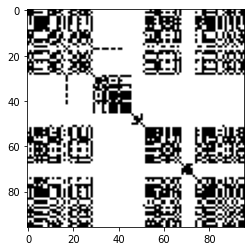

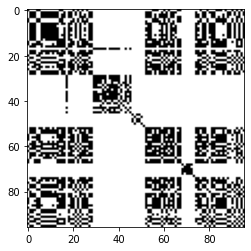

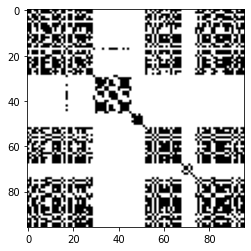

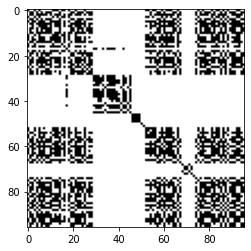

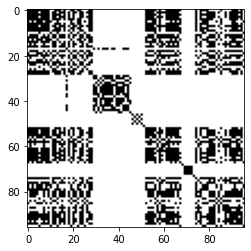

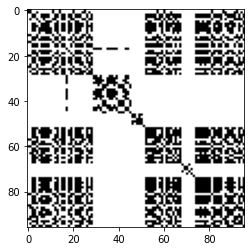

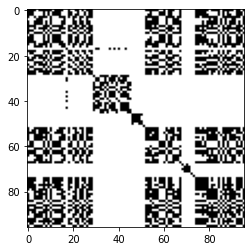

In [3]:
from matplotlib import pyplot as plt
img_num = 1
for i in range(img_num):
    plt.imshow(X[i], cmap='binary')
    plt.show()

## Model 훈련 및 결과

In [6]:
learning_rate = 3e-5
optimizer ='Adam'
loss='binary_crossentropy'
activation = 'sigmoid'
dimension = 16

In [5]:
from utils import split_data
X_train, X_test, Y_train, Y_test = split_data(X_scaled, X_scaled) #데이터 분리

In [7]:

from agent import Autoencoder_Agent
from keras import backend as K
import tensorflow as tf


autoencoder = Autoencoder_Agent(model_size=96, dimension=dimension, optimizer=optimizer,learning_rate=learning_rate,
                                activation_function=activation, loss_function=loss)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
activation_14 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 48, 48, 16)        4624      
_________________________________________________________________
activation_15 (Activation)   (None, 48, 48, 16)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 24, 24, 1)        

In [26]:
batch_size = 64
epochs = 2000

In [27]:
hist = autoencoder.train(X_train, batch_size, epochs, X_test, early_stopping=False)

Epoch 1/2000
4/4 [==============================] - 1s 157ms/step - loss: 0.2499 - val_loss: 0.2499
Epoch 2/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.2498 - val_loss: 0.2498
Epoch 3/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.2498 - val_loss: 0.2497
Epoch 4/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.2497 - val_loss: 0.2497
Epoch 5/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.2497 - val_loss: 0.2496
Epoch 6/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.2496 - val_loss: 0.2496
Epoch 7/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.2495 - val_loss: 0.2495
Epoch 8/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.2495 - val_loss: 0.2494
Epoch 9/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.2494 - val_loss: 0.2494
Epoch 10/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.2494 - val_loss: 0.2493
Epoch 11

4/4 [==============================] - 0s 23ms/step - loss: 0.2378 - val_loss: 0.2376
Epoch 84/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.2375 - val_loss: 0.2373
Epoch 85/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.2372 - val_loss: 0.2370
Epoch 86/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.2369 - val_loss: 0.2367
Epoch 87/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.2366 - val_loss: 0.2364
Epoch 88/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.2363 - val_loss: 0.2361
Epoch 89/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.2359 - val_loss: 0.2358
Epoch 90/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.2356 - val_loss: 0.2354
Epoch 91/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.2353 - val_loss: 0.2351
Epoch 92/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.2349 - val_loss: 0.2348
Epoch 93/2000


4/4 [==============================] - 0s 23ms/step - loss: 0.2050 - val_loss: 0.2047
Epoch 165/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.2047 - val_loss: 0.2044
Epoch 166/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.2044 - val_loss: 0.2041
Epoch 167/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.2041 - val_loss: 0.2038
Epoch 168/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.2037 - val_loss: 0.2034
Epoch 169/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.2034 - val_loss: 0.2031
Epoch 170/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.2031 - val_loss: 0.2028
Epoch 171/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.2028 - val_loss: 0.2025
Epoch 172/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.2026 - val_loss: 0.2023
Epoch 173/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.2023 - val_loss: 0.2020
Epoch

4/4 [==============================] - 0s 23ms/step - loss: 0.1903 - val_loss: 0.1900
Epoch 246/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1902 - val_loss: 0.1899
Epoch 247/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1901 - val_loss: 0.1899
Epoch 248/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1900 - val_loss: 0.1898
Epoch 249/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1899 - val_loss: 0.1897
Epoch 250/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1898 - val_loss: 0.1896
Epoch 251/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1897 - val_loss: 0.1895
Epoch 252/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1896 - val_loss: 0.1894
Epoch 253/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1895 - val_loss: 0.1893
Epoch 254/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1895 - val_loss: 0.1892
Epoch

4/4 [==============================] - 0s 23ms/step - loss: 0.1844 - val_loss: 0.1843
Epoch 327/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1843 - val_loss: 0.1842
Epoch 328/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1843 - val_loss: 0.1841
Epoch 329/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1842 - val_loss: 0.1841
Epoch 330/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1842 - val_loss: 0.1840
Epoch 331/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1841 - val_loss: 0.1840
Epoch 332/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1840 - val_loss: 0.1839
Epoch 333/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1840 - val_loss: 0.1838
Epoch 334/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1839 - val_loss: 0.1838
Epoch 335/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1838 - val_loss: 0.1837
Epoch

4/4 [==============================] - 0s 23ms/step - loss: 0.1789 - val_loss: 0.1787
Epoch 408/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1788 - val_loss: 0.1787
Epoch 409/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1787 - val_loss: 0.1786
Epoch 410/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1786 - val_loss: 0.1785
Epoch 411/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.1786 - val_loss: 0.1784
Epoch 412/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1785 - val_loss: 0.1784
Epoch 413/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1784 - val_loss: 0.1783
Epoch 414/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1783 - val_loss: 0.1782
Epoch 415/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1783 - val_loss: 0.1781
Epoch 416/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1782 - val_loss: 0.1781
Epoch

4/4 [==============================] - 0s 23ms/step - loss: 0.1723 - val_loss: 0.1722
Epoch 489/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1722 - val_loss: 0.1721
Epoch 490/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1721 - val_loss: 0.1720
Epoch 491/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1720 - val_loss: 0.1719
Epoch 492/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1719 - val_loss: 0.1719
Epoch 493/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1719 - val_loss: 0.1718
Epoch 494/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1718 - val_loss: 0.1717
Epoch 495/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1717 - val_loss: 0.1716
Epoch 496/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1716 - val_loss: 0.1715
Epoch 497/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1715 - val_loss: 0.1714
Epoch

4/4 [==============================] - 0s 23ms/step - loss: 0.1656 - val_loss: 0.1655
Epoch 570/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1655 - val_loss: 0.1655
Epoch 571/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1655 - val_loss: 0.1654
Epoch 572/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1654 - val_loss: 0.1653
Epoch 573/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1653 - val_loss: 0.1652
Epoch 574/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1652 - val_loss: 0.1652
Epoch 575/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1652 - val_loss: 0.1651
Epoch 576/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1651 - val_loss: 0.1650
Epoch 577/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1650 - val_loss: 0.1649
Epoch 578/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1649 - val_loss: 0.1649
Epoch

4/4 [==============================] - 0s 23ms/step - loss: 0.1602 - val_loss: 0.1601
Epoch 651/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1601 - val_loss: 0.1600
Epoch 652/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1601 - val_loss: 0.1600
Epoch 653/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1600 - val_loss: 0.1599
Epoch 654/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1600 - val_loss: 0.1598
Epoch 655/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1599 - val_loss: 0.1598
Epoch 656/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1598 - val_loss: 0.1597
Epoch 657/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1598 - val_loss: 0.1597
Epoch 658/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1597 - val_loss: 0.1596
Epoch 659/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1597 - val_loss: 0.1595
Epoch

4/4 [==============================] - 0s 23ms/step - loss: 0.1557 - val_loss: 0.1556
Epoch 732/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1556 - val_loss: 0.1555
Epoch 733/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1556 - val_loss: 0.1555
Epoch 734/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1555 - val_loss: 0.1554
Epoch 735/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1555 - val_loss: 0.1554
Epoch 736/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1554 - val_loss: 0.1553
Epoch 737/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1554 - val_loss: 0.1553
Epoch 738/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1553 - val_loss: 0.1552
Epoch 739/2000
4/4 [==============================] - 0s 27ms/step - loss: 0.1553 - val_loss: 0.1552
Epoch 740/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1552 - val_loss: 0.1551
Epoch

4/4 [==============================] - 0s 24ms/step - loss: 0.1514 - val_loss: 0.1512
Epoch 813/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.1513 - val_loss: 0.1512
Epoch 814/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.1513 - val_loss: 0.1511
Epoch 815/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1512 - val_loss: 0.1511
Epoch 816/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1512 - val_loss: 0.1510
Epoch 817/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1511 - val_loss: 0.1510
Epoch 818/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.1511 - val_loss: 0.1509
Epoch 819/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1510 - val_loss: 0.1509
Epoch 820/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1510 - val_loss: 0.1508
Epoch 821/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.1509 - val_loss: 0.1508
Epoch

4/4 [==============================] - 0s 23ms/step - loss: 0.1477 - val_loss: 0.1476
Epoch 894/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1476 - val_loss: 0.1475
Epoch 895/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1476 - val_loss: 0.1475
Epoch 896/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1476 - val_loss: 0.1475
Epoch 897/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.1475 - val_loss: 0.1474
Epoch 898/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.1475 - val_loss: 0.1474
Epoch 899/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.1474 - val_loss: 0.1473
Epoch 900/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.1474 - val_loss: 0.1473
Epoch 901/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.1474 - val_loss: 0.1473
Epoch 902/2000
4/4 [==============================] - 0s 25ms/step - loss: 0.1473 - val_loss: 0.1472
Epoch

4/4 [==============================] - 0s 22ms/step - loss: 0.1447 - val_loss: 0.1447
Epoch 975/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1447 - val_loss: 0.1447
Epoch 976/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1447 - val_loss: 0.1446
Epoch 977/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1447 - val_loss: 0.1446
Epoch 978/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1446 - val_loss: 0.1446
Epoch 979/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1446 - val_loss: 0.1446
Epoch 980/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1446 - val_loss: 0.1445
Epoch 981/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.1445 - val_loss: 0.1445
Epoch 982/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.1445 - val_loss: 0.1445
Epoch 983/2000
4/4 [==============================] - 0s 25ms/step - loss: 0.1445 - val_loss: 0.1444
Epoch

4/4 [==============================] - 0s 23ms/step - loss: 0.1425 - val_loss: 0.1425
Epoch 1055/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1425 - val_loss: 0.1425
Epoch 1056/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1424 - val_loss: 0.1424
Epoch 1057/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1424 - val_loss: 0.1424
Epoch 1058/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.1424 - val_loss: 0.1424
Epoch 1059/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.1424 - val_loss: 0.1424
Epoch 1060/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1423 - val_loss: 0.1423
Epoch 1061/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.1423 - val_loss: 0.1423
Epoch 1062/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1423 - val_loss: 0.1423
Epoch 1063/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1423 - val_loss: 0.1

4/4 [==============================] - 0s 23ms/step - loss: 0.1407 - val_loss: 0.1407
Epoch 1135/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1406 - val_loss: 0.1407
Epoch 1136/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1406 - val_loss: 0.1406
Epoch 1137/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1406 - val_loss: 0.1406
Epoch 1138/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1406 - val_loss: 0.1406
Epoch 1139/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1405 - val_loss: 0.1406
Epoch 1140/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1405 - val_loss: 0.1406
Epoch 1141/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1405 - val_loss: 0.1405
Epoch 1142/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1405 - val_loss: 0.1405
Epoch 1143/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1405 - val_loss: 0.1

4/4 [==============================] - 0s 23ms/step - loss: 0.1389 - val_loss: 0.1391
Epoch 1215/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1389 - val_loss: 0.1391
Epoch 1216/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.1389 - val_loss: 0.1391
Epoch 1217/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1389 - val_loss: 0.1390
Epoch 1218/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1388 - val_loss: 0.1390
Epoch 1219/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1388 - val_loss: 0.1390
Epoch 1220/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1388 - val_loss: 0.1390
Epoch 1221/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1388 - val_loss: 0.1390
Epoch 1222/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1387 - val_loss: 0.1389
Epoch 1223/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1387 - val_loss: 0.1

4/4 [==============================] - 0s 23ms/step - loss: 0.1371 - val_loss: 0.1373
Epoch 1295/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1371 - val_loss: 0.1373
Epoch 1296/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1370 - val_loss: 0.1373
Epoch 1297/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1370 - val_loss: 0.1372
Epoch 1298/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1370 - val_loss: 0.1372
Epoch 1299/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.1369 - val_loss: 0.1371
Epoch 1300/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1369 - val_loss: 0.1371
Epoch 1301/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1369 - val_loss: 0.1371
Epoch 1302/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1368 - val_loss: 0.1370
Epoch 1303/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1368 - val_loss: 0.1

4/4 [==============================] - 0s 23ms/step - loss: 0.1348 - val_loss: 0.1348
Epoch 1375/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1348 - val_loss: 0.1348
Epoch 1376/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1347 - val_loss: 0.1348
Epoch 1377/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1347 - val_loss: 0.1348
Epoch 1378/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1347 - val_loss: 0.1347
Epoch 1379/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1347 - val_loss: 0.1347
Epoch 1380/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1346 - val_loss: 0.1347
Epoch 1381/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1346 - val_loss: 0.1347
Epoch 1382/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1346 - val_loss: 0.1346
Epoch 1383/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1346 - val_loss: 0.1

4/4 [==============================] - 0s 23ms/step - loss: 0.1329 - val_loss: 0.1328
Epoch 1455/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1328 - val_loss: 0.1328
Epoch 1456/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1328 - val_loss: 0.1327
Epoch 1457/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1328 - val_loss: 0.1327
Epoch 1458/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1328 - val_loss: 0.1327
Epoch 1459/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1327 - val_loss: 0.1327
Epoch 1460/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1327 - val_loss: 0.1327
Epoch 1461/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1327 - val_loss: 0.1326
Epoch 1462/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1327 - val_loss: 0.1326
Epoch 1463/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1327 - val_loss: 0.1

4/4 [==============================] - 0s 22ms/step - loss: 0.1310 - val_loss: 0.1309
Epoch 1535/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1310 - val_loss: 0.1309
Epoch 1536/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1309 - val_loss: 0.1308
Epoch 1537/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1309 - val_loss: 0.1308
Epoch 1538/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1309 - val_loss: 0.1308
Epoch 1539/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1309 - val_loss: 0.1307
Epoch 1540/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1308 - val_loss: 0.1307
Epoch 1541/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1308 - val_loss: 0.1307
Epoch 1542/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1308 - val_loss: 0.1307
Epoch 1543/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1307 - val_loss: 0.1

4/4 [==============================] - 0s 23ms/step - loss: 0.1288 - val_loss: 0.1287
Epoch 1615/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1288 - val_loss: 0.1287
Epoch 1616/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1287 - val_loss: 0.1286
Epoch 1617/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1287 - val_loss: 0.1286
Epoch 1618/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1287 - val_loss: 0.1286
Epoch 1619/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.1287 - val_loss: 0.1285
Epoch 1620/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1286 - val_loss: 0.1285
Epoch 1621/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1286 - val_loss: 0.1285
Epoch 1622/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1286 - val_loss: 0.1285
Epoch 1623/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1285 - val_loss: 0.1

4/4 [==============================] - 0s 22ms/step - loss: 0.1269 - val_loss: 0.1268
Epoch 1695/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1269 - val_loss: 0.1268
Epoch 1696/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1268 - val_loss: 0.1268
Epoch 1697/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1268 - val_loss: 0.1267
Epoch 1698/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1268 - val_loss: 0.1267
Epoch 1699/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1268 - val_loss: 0.1267
Epoch 1700/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1267 - val_loss: 0.1267
Epoch 1701/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1267 - val_loss: 0.1266
Epoch 1702/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1267 - val_loss: 0.1266
Epoch 1703/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1267 - val_loss: 0.1

4/4 [==============================] - 0s 22ms/step - loss: 0.1251 - val_loss: 0.1250
Epoch 1775/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1251 - val_loss: 0.1250
Epoch 1776/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1251 - val_loss: 0.1250
Epoch 1777/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1251 - val_loss: 0.1249
Epoch 1778/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1251 - val_loss: 0.1249
Epoch 1779/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1250 - val_loss: 0.1249
Epoch 1780/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1250 - val_loss: 0.1249
Epoch 1781/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1250 - val_loss: 0.1248
Epoch 1782/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1250 - val_loss: 0.1248
Epoch 1783/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1249 - val_loss: 0.1

4/4 [==============================] - 0s 22ms/step - loss: 0.1231 - val_loss: 0.1228
Epoch 1855/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1231 - val_loss: 0.1228
Epoch 1856/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1230 - val_loss: 0.1228
Epoch 1857/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1230 - val_loss: 0.1227
Epoch 1858/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1230 - val_loss: 0.1227
Epoch 1859/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1230 - val_loss: 0.1227
Epoch 1860/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1229 - val_loss: 0.1227
Epoch 1861/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1229 - val_loss: 0.1226
Epoch 1862/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1229 - val_loss: 0.1226
Epoch 1863/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1228 - val_loss: 0.1

4/4 [==============================] - 0s 23ms/step - loss: 0.1209 - val_loss: 0.1206
Epoch 1935/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.1209 - val_loss: 0.1206
Epoch 1936/2000
4/4 [==============================] - 0s 24ms/step - loss: 0.1208 - val_loss: 0.1205
Epoch 1937/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1208 - val_loss: 0.1205
Epoch 1938/2000
4/4 [==============================] - 0s 23ms/step - loss: 0.1208 - val_loss: 0.1205
Epoch 1939/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1208 - val_loss: 0.1205
Epoch 1940/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1207 - val_loss: 0.1204
Epoch 1941/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1207 - val_loss: 0.1204
Epoch 1942/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1207 - val_loss: 0.1204
Epoch 1943/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.1206 - val_loss: 0.1

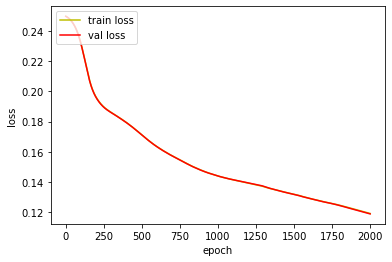

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()


loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
# loss_ax.plot([hist['loss'][i] - hist['val_loss'][i] for i in range(len(hist['loss']))], 'g', label='loss - val loss')


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

### feature 추출

In [49]:
# it = int(X_scaled.shape[0] / 30) 
all_feature = np.array(autoencoder.feature_extract(X_scaled))
# for i in range(1, it):
#     feature = autoencoder.feature_extract(X_scaled[i*30:(i+1)*30])
#     all_feature = np.concatenate([all_feature, feature])
print(all_feature)
print(all_feature.shape)

[[0.8292294  0.8080773  0.45247382 ... 0.5628219  0.10692786 0.51154375]
 [0.74569863 0.8572211  0.5518558  ... 0.6749711  0.         0.6510197 ]
 [0.6724663  0.804042   0.5017713  ... 0.5374559  0.22286505 0.69716424]
 ...
 [0.7884185  0.9765495  0.56653726 ... 0.41386324 0.16424179 0.915282  ]
 [0.75562376 0.98036873 0.69329906 ... 0.29310393 0.41627938 0.8684908 ]
 [0.79665023 0.94846153 0.6784046  ... 0.33910185 0.42158365 0.8114713 ]]
(300, 288)


## 군집화 및 군집 결과

In [50]:
from sklearn.cluster import KMeans
# Cluster Algorithm
cluster_result = KMeans(n_clusters=3).fit(all_feature)

In [51]:
labels_ = cluster_result.labels_ + 1
dic_labels_ = {}
for i in labels_:
    if f'{i}' not in dic_labels_.keys():
        dic_labels_[f'{i}'] = 1
    else:
        dic_labels_[f'{i}'] += 1

for key, value in dic_labels_.items():
    print(f"{key}: {value}")

3: 50
1: 150
2: 100


### 실루엣 분석

In [64]:
from sklearn.metrics import silhouette_samples,silhouette_score
def plotSilhouette(X, y_km):
    cluster_labels = np.unique(y_km.labels_)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_score(X, y_km.labels_,metric='euclidean')
#     print(silhouette_vals)
    return silhouette_vals

res = plotSilhouette(result,cluster_result)
print(res)

0.35974432830743003


### 추출 feature 값 결과

In [ ]:
# 1. 해당 dimension 에서 100번 돌려서 제일 좋은 결과를 뽑는다.
cluster = 3
max_result = -1
for _ in range(100):
    cluster_result = KMeans(n_clusters=cluster).fit(all_feature)
    sil_res = plotSilhouette(result, cluster_result)
    if max_result < sil_res:
        max_result = sil_res
print(f"군집 {cluster} 최대 실루엣 점수: {max_result}")

In [72]:
# 2. 1 ~ 100 군집 개수로 인한 결과 중에서 가장 좋은 결과를 뽑는다.
max_case_result = -1
max_case_cluster_n = 0
for i in range(2, 101):
    var_result = KMeans(n_clusters=i).fit(all_feature)
    sil_res = plotSilhouette(result,var_result)
    if max_case_result < sil_res:
        max_case_result = sil_res
        max_case_cluster_n = i
print(f"최대 실루엣 점수: {max_case_result}\n군집개수: {max_case_cluster_n}")

최대 실루엣 점수: 0.5895107847277465
군집개수: 4


### 원 시계열 데이터 결과

In [75]:
# 1. 해당 dimension 에서 100번 돌려서 제일 좋은 결과를 뽑는다.
cluster = 3
max_result = -1
for _ in range(100):
    cluster_result = KMeans(n_clusters=cluster).fit(result)
    sil_res = plotSilhouette(result, cluster_result)
    if max_result < sil_res:
        max_result = sil_res
print(f"군집 {cluster} 최대 실루엣 점수: {max_result}")

군집 3 최대 실루엣 점수: 0.5287731200571689


In [74]:
# 2. 1 ~ 100 군집 개수로 인한 결과 중에서 가장 좋은 결과를 뽑는다.
max_case_result = -1
max_case_cluster_n = 0
for i in range(2, 101):
    var_result = KMeans(n_clusters=i).fit(result)
    sil_res = plotSilhouette(result,var_result)
    if max_case_result < sil_res:
        max_case_result = sil_res
        max_case_cluster_n = i
print(f"최대 실루엣 점수: {max_case_result}\n군집개수: {max_case_cluster_n}")

최대 실루엣 점수: 0.5895107847277465
군집개수: 4
